In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

# Exploration

### Load trained models

In [3]:
from baseline import Baseline

In [4]:
from genhebb import GenHebb, hebbs_rule, random_W, FastMNIST

In [5]:
hebbs_rule1 = GenHebb(28*28, 2000, 10, hebbs_rule)
hebbs_rule5 = GenHebb(28*28, 2000, 10, hebbs_rule)
hebbs_rule10 = GenHebb(28*28, 2000, 10, hebbs_rule)
hebbs_rule50 = GenHebb(28*28, 2000, 10, hebbs_rule)
random_W = GenHebb(28*28, 2000, 10, random_W)
baseline = Baseline(28*28, 2000, 10)

In [6]:
hebbs_rule1.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-1_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
hebbs_rule5.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-5_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
hebbs_rule10.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-10_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
hebbs_rule50.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-50_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
random_W.load_state_dict(torch.load('saved_models/genhebb-random_W-1_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
baseline.load_state_dict(torch.load('saved_models/baseline-50_epochs-0.001_lr-64_batch.pt'))

<All keys matched successfully>

### Investigate unsup layer weight matrix

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=2)

In [9]:
trainset = FastMNIST('./data', train=True, download=True)

In [10]:
images, labels = next(iter(DataLoader(trainset, batch_size=5000, shuffle=True)))

In [11]:
x = images.reshape(-1, 28*28)
x_proj = pca.fit_transform(x)

In [19]:
Wx_hebbs_rule1 = hebbs_rule1.unsup_layer(x)
Wx_proj_hebbs_rule1 = pca.fit_transform(Wx_hebbs_rule1.detach())
Wx_hebbs_rule5 = hebbs_rule5.unsup_layer(x)
Wx_proj_hebbs_rule5 = pca.fit_transform(Wx_hebbs_rule5.detach())
Wx_hebbs_rule10 = hebbs_rule10.unsup_layer(x)
Wx_proj_hebbs_rule10 = pca.fit_transform(Wx_hebbs_rule10.detach())
Wx_hebbs_rule50 = hebbs_rule50.unsup_layer(x)
Wx_proj_hebbs_rule50 = pca.fit_transform(Wx_hebbs_rule50.detach())
Wx_random_W = random_W.unsup_layer(x)
Wx_proj_random_W = pca.fit_transform(Wx_random_W.detach())

In [20]:
Wx_baseline = baseline.input(x)
Wx_proj_baseline = pca.fit_transform(Wx_baseline.detach())

Text(0.5, 1.0, 'Embeddings (50 Unsup. Epochs)')

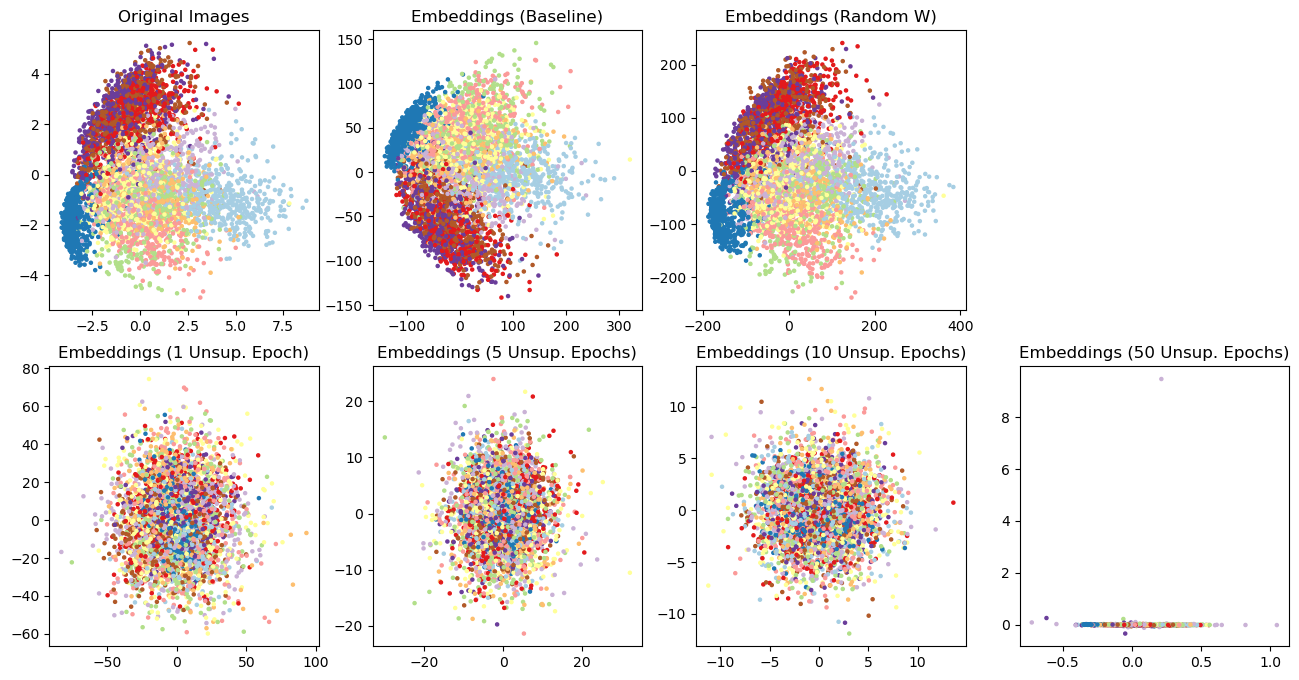

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0, 0].scatter(x_proj[:, 0], x_proj[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 1].scatter(Wx_proj_baseline[:, 0], Wx_proj_baseline[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 2].scatter(Wx_proj_random_W[:, 0], Wx_proj_random_W[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 0].scatter(Wx_proj_hebbs_rule1[:, 0], Wx_proj_hebbs_rule1[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 1].scatter(Wx_proj_hebbs_rule5[:, 0], Wx_proj_hebbs_rule5[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 2].scatter(Wx_proj_hebbs_rule10[:, 0], Wx_proj_hebbs_rule10[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 3].scatter(Wx_proj_hebbs_rule50[:, 0], Wx_proj_hebbs_rule50[:, 1], c=labels, cmap='Paired', s=5)

axes[0, 0].set_title('Original Images')
axes[0, 1].set_title('Embeddings (Baseline)')
axes[0, 2].set_title('Embeddings (Random W)')
axes[0, 3].axis('off')
axes[1, 0].set_title('Embeddings (1 Unsup. Epoch)')
axes[1, 1].set_title('Embeddings (5 Unsup. Epochs)')
axes[1, 2].set_title('Embeddings (10 Unsup. Epochs)')
axes[1, 3].set_title('Embeddings (50 Unsup. Epochs)')
# fig.savefig('figures/embeddings_comparison.png', dpi=300)

In [95]:
def plot_neuron_similarities(model, num_samples):
    # get and normalize weight matrix
    try:
        W = model.unsup_layer.W
    except:
        W = model.input.weight
    W_normed = F.normalize(W)
    
    # get pairwise cosine similarities
    similarities = torch.matmul(W_normed, W_normed.T)
    similarities = similarities[~torch.eye(similarities.size(0), dtype=bool)].flatten().detach()
    
    # sample similarities
    indices = torch.randperm(similarities.size(0))[:num_samples]
    similarities_sample = similarities[indices]
    
    # plot
    plt.hist(similarities_sample.numpy(), bins=20, range=(-1,1), weights=np.ones(num_samples)/num_samples, edgecolor='black')
    plt.xlabel('Cosine Similarities Between Neurons')
    plt.ylabel('Fraction')
    plt.show()

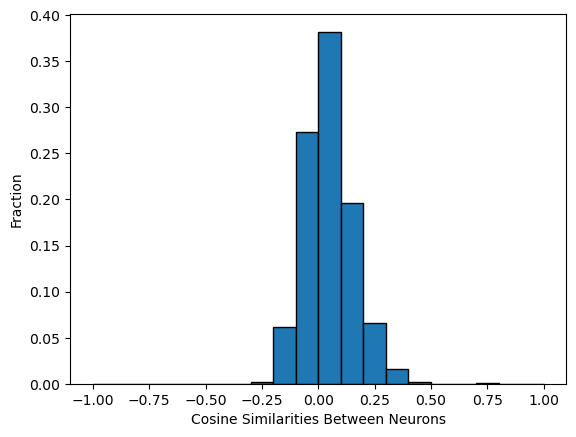

In [96]:
plot_neuron_similarities(baseline, 1000)

### Implement Oja's rule

In [12]:
W = torch.rand(3, 2)

In [13]:
x = torch.tensor([1, 0])

In [14]:
y = torch.rand(3)

In [186]:
o = torch.tensor([1, 1])

In [187]:
torch.matmul(y.unsqueeze(-2) * o.unsqueeze(-1), W)

tensor([[0, 3],
        [0, 3]])

In [188]:
W.shape

torch.Size([3, 2])

In [189]:
(y.unsqueeze(-1)*W).shape

torch.Size([3, 2])

In [190]:
y.unsqueeze(-1).shape

torch.Size([3, 1])

In [202]:
W.unsqueeze(0).shape

torch.Size([1, 3, 2])

In [210]:
torch.sum((y**2).unsqueeze(-1) * W.unsqueeze(0), 0)

tensor([[0.0058, 0.0094],
        [0.0453, 0.0655],
        [0.1312, 0.3899]])

In [207]:
((y**2).unsqueeze(-1) * W)

tensor([[0.0058, 0.0094],
        [0.0453, 0.0655],
        [0.1312, 0.3899]])

#### Test Oja's rule (bug?)

In [1]:
from genhebb import ojas_rule

/opt/anaconda3/envs/hebbian/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
ojas_rule(x, y, W)